# Self Study 2: Random Growth Models

In this notebook, we will study the growth of firms as described by the Gibrat's law.
To do so, we will first look at the central limit theorem to see how the mean of any distribution converges to a normal distribution.

We then simulate the growth of firms and show that the distribution of firm sizes converges to a log-normal distribution.

In [586]:
# Importing the libraries
import numpy as np  # for numerical computations
import matplotlib.pyplot as plt # for plotting
import scipy.stats as stats # for statistical analysis

## Section 1: Central Limit Theorem

### Task 1: Visualize Random Variable Distributions

In this task, we aim to understand how random variables from different distributions can be generated and visualized using Python. We'll focus on two distributions:
- A **Uniform Distribution**
- A **Normal Distribution**

We'll use the `numpy` library for generating these random variables and the `matplotlib.pyplot` library to plot their distributions.

#### Step 1: Generate Random Variables
First, let's generate 1000 random variables from:
- A uniform distribution between 0 and 4.
- A normal distribution with a mean of 2 and a standard deviation of 1.

In [587]:
np.random.seed(0)  # seed for reproducibility
sample_size = 1000
data_uniform = np.random.uniform(low=0, high=4, size=sample_size) # YOUR CODE HERE
data_normal = np.random.normal(loc=2, scale=1, size=sample_size) # YOUR CODE HERE

#### Step 2: Plot the Distributions
Next, we'll plot the histogram of these random variables to visualize their distributions. We'll use different colors and labels to distinguish between them.


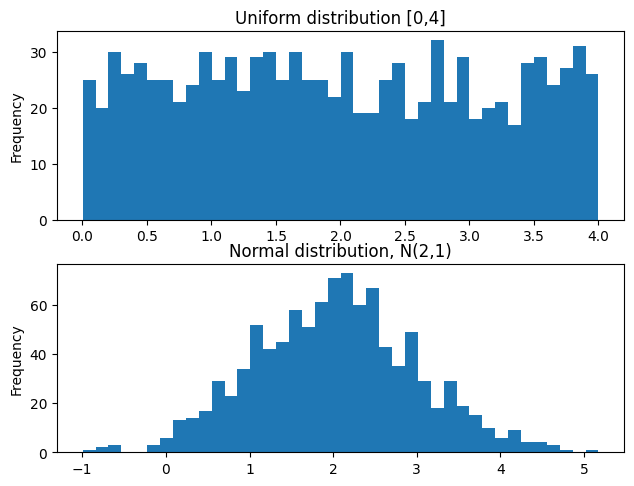

In [588]:
# Plot the histograms using plt.hist() function (40 bins)

fig, axs = plt.subplots(2,1)
fig.tight_layout()
axs[0].hist(data_uniform, 40)
axs[0].set_title("Uniform distribution [0,4]")
axs[0].set_ylabel("Frequency")
axs[1].hist(data_normal, 40)
axs[1].set_title("Normal distribution, N(2,1)")
axs[1].set_ylabel("Frequency")
plt.show()


### Task 2: Bimodal Mixture Distribution

Create a function for a bimodal mixture distribution, drawing 50% of its values from one normal distribution ($N(\mu_1, \sigma_1)$) and 50% from another ($N(\mu_2, \sigma_2)$).
The goal is to generate data samples which half the time come from one normal distribution and half the time from another (i.e., a mixture of two normal distributions).

In [589]:
import numpy as np

def mixture_model(n_agents, n_tries, mu_1=1.0, sigma_1=0.5, mu_2=3.0, sigma_2=0.5):
    """
    Generates data from a bimodal mixture distribution.
    
    Parameters:
        n_agents (int): Number of agents generating data.
        n_tries (int): Number of data points per agent.
        mu_1, sigma_1 (float): Mean and std of the first normal distribution.
        mu_2, sigma_2 (float): Mean and std of the second normal distribution.
    
    Returns:
        np.ndarray: Data points from the bimodal mixture.
    """
    
    # First and second normal distribution samples
    samples_normal_1 = np.random.normal(loc=mu_1, scale=sigma_1, size=n_tries) # YOUR CODE HERE
    samples_normal_2 = np.random.normal(loc=mu_2, scale=sigma_2, size=n_tries) # YOUR CODE HERE
    
    # Random selection between the two distributions
    first_or_second = np.random.uniform(0, 1, (n_agents, n_tries)) < 0.5
    samples = np.where(first_or_second, samples_normal_1, samples_normal_2)
    
    return samples.squeeze()  # remove the singleton dimension if n_agents=1


Sample 1000 random variables using the `mixture_model` function, then visualize the distribution with `plt.hist`.

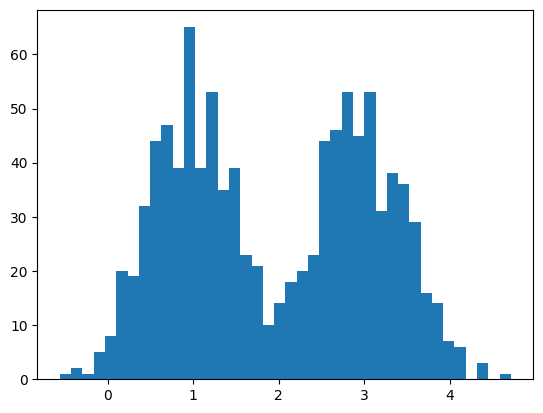

In [590]:
# YOUR CODE HERE
data_mixture_model = mixture_model(1, 1000)

plt.hist(data_mixture_model, 40)
plt.show()

### Task 3: Central Limit Theorem

Step 1: Plot Histogram of Sample Means

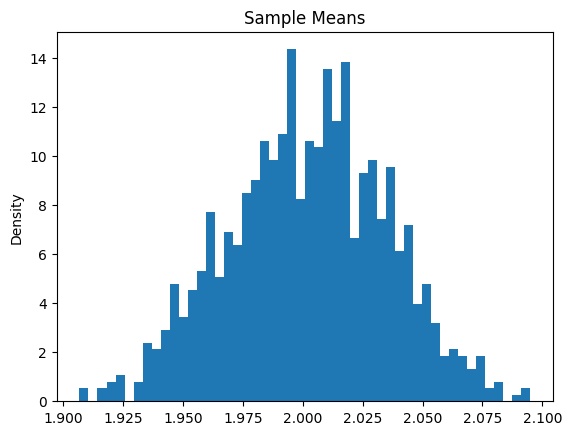

In [591]:
def plot_clt_histogram(samples, bins=50):
    """Plot the histogram of the sample means.
    
    Parameters:
        samples (np.ndarray): 2D array with the samples; n_agents x n_tries.
        bins (int): Number of bins in the histogram.
    """
    # compute the sample means for each agent and store them in means
    means = np.mean(samples, axis=1)
    
    plt.hist(means, bins=bins, density=True, label='Sample Means')
    plt.title('Sample Means')
    plt.ylabel('Density')

plot_clt_histogram(mixture_model(1000,1000))

Step 2: Plot Theoretical Normal Distribution Curve

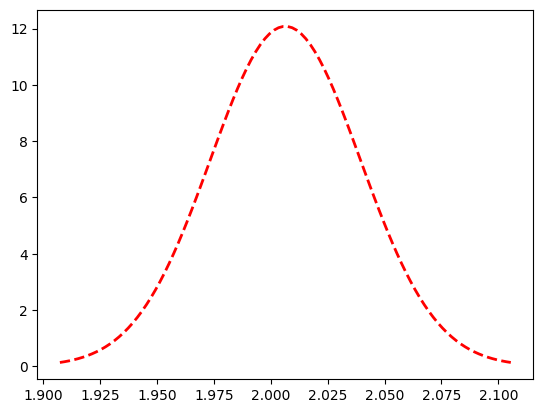

In [592]:
def plot_clt_pdf(samples):
    """Plot the theoretical normal distribution curve.
    
    Parameters:
        samples (np.ndarray): 2D array with the samples; n_agents x n_tries.
    """
    # Calculate and plot the theoretical normal distribution curve
    n_agents = samples.shape[1]
    
    means = np.mean(samples, axis=1)
    # mu = mean of the sample means
    mu = np.mean(means) # YOUR CODE HERE
    
    # std = std of the sample means divided by sqrt(n_agents)
    #! Looked awful when divided by sqrt(n_agents) and looks correct without doing it
    std = np.std(means) # YOUR CODE HERE
    
    x = np.linspace(mu - 3*std, mu + 3*std, 100)
    y = stats.norm.pdf(x, mu, std)
    plt.plot(x, y, 'r--', linewidth=2, label='Theoretical Normal Dist.')

mixture_data = mixture_model(1000,1000)
plot_clt_pdf(mixture_data)


Step 3: Plot Histogram of Sample Means for Different Sample Sizes

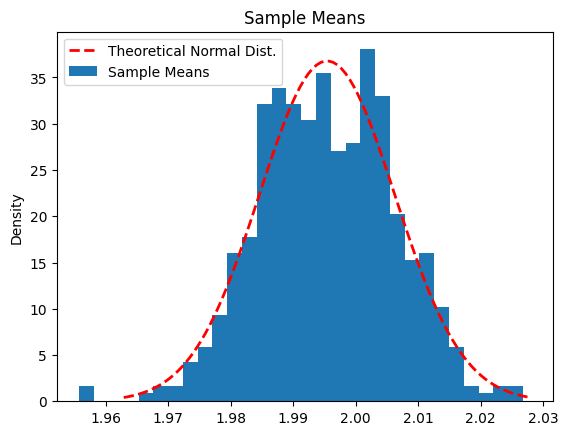

In [593]:
# Generate 500 samples of the mixture model to test the functions below
mix_samples = mixture_model(500,10000)# YOUR CODE HERE

plot_clt_pdf(mix_samples)
plot_clt_histogram(mix_samples, bins=30)
plt.legend()
plt.show()

A wonderful visualization of the Central Limit Theorem can be found [here](https://seeing-theory.brown.edu/probability-distributions/index.html#section3).

## Section 2: Random Growth

We are modeling a process where each step's value is the product of the previous step's value and a growth rate. The process starts with an initial value \(x_0\) and grows step by step. Here's how it works:

At the first step:
$$x_1 = x_0 \cdot \lambda_0$$

At the second step:
$$x_2 = x_1 \cdot \lambda_1$$

This pattern continues such that for any step \(s\), the value is:
$$x_s = x_{s-1} \cdot \lambda_{s-1}$$

We can generalize this for any step \(t\) using the product notation:
$$x_t = x_0 \cdot \prod_{s=0}^{t-1} \lambda_s$$

Here, $x_0$ is the starting value, and $\lambda_i > 0$ represents the growth rate at step $i$. Our goal is to calculate the value of $x_n$ given $x_0$ and the growth rates $\lambda_i$.


### Task 1: Simulate Firm Growth

Complete the function `simulate_growth` to simulate the growth of a firm over time.

In [594]:
# np.random.seed(42) # again for reproducibility

def simulate_growth(n_agents, n_steps, x0=1, *, mu_1=1.2, sigma_1=.05, mu_2=0.9, sigma_2=.05):
    """Simulates the growth of a number of agents over time.
      
    Parameters:
        n_agents (int): Number of agents.
        n_steps (int): Number of growth steps.
        x0 (float): Initial value of the growth.
        mu_1, sigma_1 (float): Mean and std of the first normal distribution.
        mu_2, sigma_2 (float): Mean and std of the second normal distribution.
    """
    # get the lambdas from the mixture model
    lambdas = mixture_model(n_agents=n_agents, n_tries=n_steps, mu_1=mu_1, sigma_1=sigma_1, mu_2=mu_2, sigma_2=sigma_2)

    # growth rates must be positive
    lambdas = np.abs(lambdas)

    # Step 2: compute the growth
    # YOUR CODE HERE (hint: use np.cumprod() or a for loop)
    # evolution=np.empty((n_agents, n_steps))
    evolution = []
    for arr in lambdas:
        cum_product = np.cumprod(arr)*x0
        evolution.append(cum_product)

    np_array = np.array(evolution)
    return np_array, lambdas

# print(simulate_growth(10, 5))

### Task 2: Plot the evolution of a firm's size

arithmetic_mean=1.0349, geometric_mean=1.0241


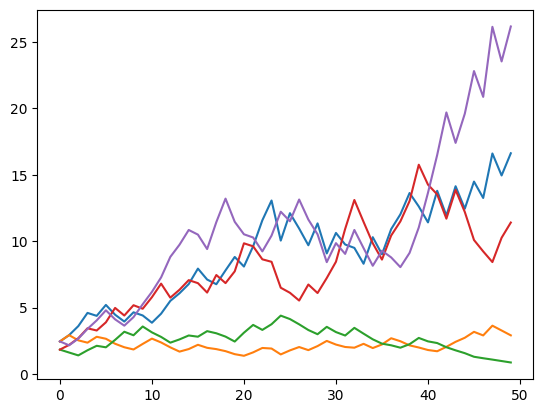

In [618]:
# Step 3: plot the evolution of the random growth
np.random.seed(42)
firm_size_evolution, lambdas = simulate_growth(5,50, x0=2)# YOUR CODE HERE
plt.plot(firm_size_evolution.T)
# plt.yscale('log')

# Compute the arithmetic and geometric means

arithmetic_mean = np.mean(lambdas)
geometric_mean = np.exp(np.mean(np.log(lambdas)))
print(f"{arithmetic_mean=:0.4f}, {geometric_mean=:0.4f}")


### Task 3: Plot the distribution of final firm sizes

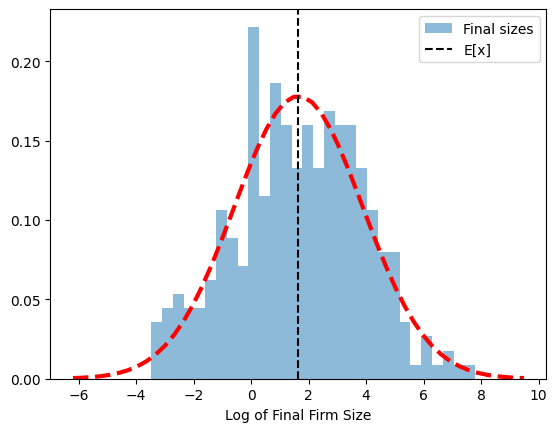

In [619]:
# Set a random seed for reproducibility
np.random.seed(884)

# Simulate firm growth with many agents
firm_size_evolution, lambdas = simulate_growth(n_agents=300, n_steps=1_000, mu_1=1.07, sigma_1=0.05, mu_2=0.94, sigma_2=0.05)

# Calculate the logarithm of the final sizes for all firms
final_sizes = np.log(firm_size_evolution[:, -1]) # YOUR CODE HERE

# Plot the histogram of the final sizes to visualize their distribution
plt.hist(final_sizes, bins=30, alpha=0.5, label='Final sizes', density=True)
plt.xlabel('Log of Final Firm Size')

# Compute and print the mean and standard deviation of the final sizes
mu, std = np.mean(final_sizes), np.std(final_sizes)

# Plot the normal distribution around empirical mean
x = np.linspace(mu - 3.5*std, mu + 3.5*std, 50) # X values for plotting
y = stats.norm.pdf(x, loc=mu, scale=std)       # Y values for plotting
plt.plot(x, y, 'r--', linewidth=3, label='')

# Calculate and plot the expected value of the final size on the histogram
expected_value = mu 
plt.axvline(expected_value, color='k', linestyle='--', label='E[x]')
plt.legend()
plt.show()
